In [1]:
import os 
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.measure import label, regionprops , find_contours
from skimage.filters import threshold_local
from scipy.ndimage import median_filter
from skimage import morphology
import matplotlib.patches as patches
import matplotlib.colors as colors
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):


    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [2]:
wt_folder = "TD-WT" # set this to the path of the folder containing the wild-type images
mt_folder = "TD-MT" # set this to the path of the folder containing the mutant images
folders = [wt_folder,mt_folder]
my_colors = [(x,0,0) for x in np.linspace(0,1,1024)]
cmap = colors.ListedColormap(my_colors)





In [3]:
both_l2counts = []
for folder in folders:
    files = [folder+"/"+file for file in os.listdir(folder)]
    l2counts = []
    for file in files:
        image = tf.imread(file)
        filt_tomato_file = ndimage.median_filter(image,size = (10,10))
        block_size = 51

        binary_adaptive_filt = threshold_local(filt_tomato_file, block_size, offset=-25)
        bool_pix_filt = filt_tomato_file > binary_adaptive_filt

        ### Uncomment for morphological opening and closing for bad S/N ratios. Shouldn't be used on very small ROIs
        # open_size = 3 #probably dont touch
        # close_size = 3 #how big holes do we fill, rarely touch but maybe
        # nr_loops = 1 #how many rounds of progressively rougher filtering



        # opened_pix = 0
        # closed_pix = bool_pix_filt
        # for x in range(nr_loops):
        #     opened_pix  = ndimage.binary_opening(closed_pix,structure=np.ones([open_size+x,open_size+x]).astype(int))
        #     closed_pix  = ndimage.binary_closing(opened_pix,structure=np.ones([close_size+x,close_size+x]).astype(int))
        #  bool_pix_filt = closed_pix



        area_threshold = 50

        blobs = label(bool_pix_filt> 0,connectivity = 1)
        props = regionprops(blobs)
        blob_nrs = []
        for x in range(len(props)):
            if props[x].area < area_threshold:
                blobs[blobs == x+1] = 0
            else:
                blob_nrs.append(x)
        props = regionprops(blobs)
        for x in range(len(props)):   
            contour =find_contours(blobs, blob_nrs[x])[0]
        start = props[0].centroid[0]
        l2props = []
        for prop in props:
            if prop.centroid[0]-start < 200:
                l2props.append(prop)
        l2counts.append(len(l2props))
    both_l2counts.append(l2counts)


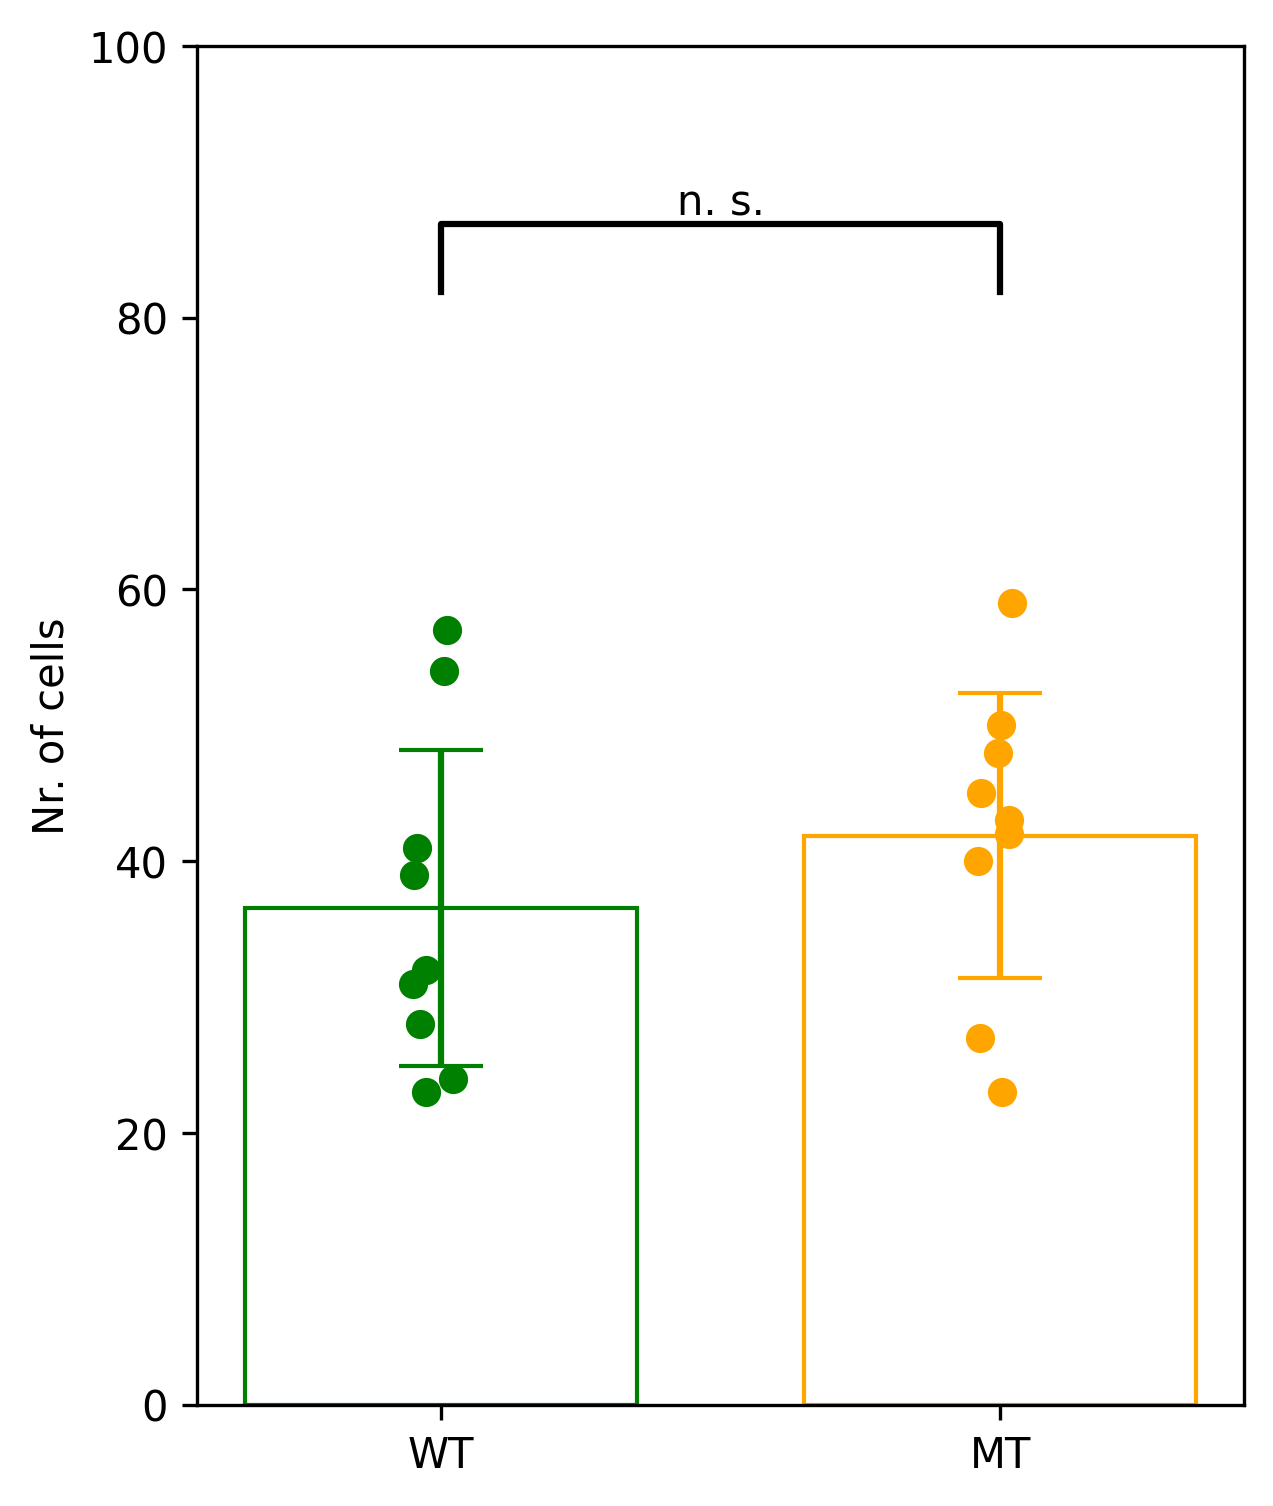

In [4]:
from scipy.stats import mannwhitneyu
import random
p_val = mannwhitneyu(both_l2counts[0],both_l2counts[1])[1]

colors = ["green","orange"]
plt.figure(figsize = (4.5,6),dpi = 300)
plt.bar("WT",np.mean(both_l2counts[0]),0.7,0,yerr = np.std(both_l2counts[0]),edgecolor = 'green',ecolor = 'green',fill=False,capsize  = 10)
plt.bar("MT",np.mean(both_l2counts[1]),0.7,0,yerr = np.std(both_l2counts[1]),edgecolor = 'orange',ecolor = 'orange',fill=False,capsize  = 10)
rand_size = 10
for cond in range(2):
    plt.scatter([cond+random.random()/rand_size-0.5/rand_size for x in range(len(both_l2counts[cond]))],both_l2counts[cond],color = colors[cond],zorder = 3)
plt.ylim([0,100])
barplot_annotate_brackets(0, 1, p_val, [0,1],[np.mean(both_l2counts[0]),np.mean(both_l2counts[1])],dh=0.4)
plt.ylabel('Nr. of cells')
plt.show()